<a href="https://colab.research.google.com/github/pcummer/deep_learning_short_projects/blob/main/Protein_folding_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Very initial work**

This is an exploratory project to play around with applying various NLP techniques to predict the secondary structure of a protein from the amino acid sequence. Right now, I just have the foundation of loading the data and training a toy model. 

There's a lot of directions to take this with likely highlights being deploying a proper NLP model like a biLSTM with randomly initialized embeddings for the amino acids, exploring those embeddings to see if they capture the similarities we'd expect i.e. arginine and lysine are close in that space, and incorporating biophysical properties of the amino acids such as electronegativity and flags for special amino acids such as proline.

We won't worry about optimizing the details of model architecture and training for the most part. If we end up with something particularly high performing we may dig into it.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.train
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.test

In [132]:
import pandas as pd
import numpy as np

def parse_to_df(path):
  with open(path,'r') as f:
    content = f.readlines()
  df = pd.DataFrame()
  protein_count = 0
  amino_acids = []
  structure = []
  for i in content:
    i = i.strip()
    if 'end' in i:
        df = df.append(pd.DataFrame({'amino_acid':[amino_acids], 'structure':[structure], 'protein_count':[protein_count]}))
        protein_count += 1
        amino_acids = []
        structure = []
    elif len(i) == 3:
      amino_acids.append(i.split(' ')[0])
      structure.append(i.split(' ')[1])
  return df

Here we load the text files for the train and test splits into easily accessed dataframes. We also also assign an index to each amino acid and structure to replace the text character.

In [133]:
df_train_raw = parse_to_df('/content/protein-secondary-structure.train')
df_test_raw = parse_to_df('/content/protein-secondary-structure.test')


unique_amino_acids_in_train = np.unique([item for sublist in df_train_raw.amino_acid for item in sublist])
unique_amino_acids_in_test = np.unique([item for sublist in df_test_raw.amino_acid for item in sublist])
[unique_amino_acids_in_train.append(x) for x in unique_amino_acids_in_test if x not in unique_amino_acids_in_train]

amino_acid_to_index = {}
i=0
for x in unique_amino_acids_in_train:
  amino_acid_to_index[x] = i
  i += 1


structure_to_index = {'_': 0, 'h': 1, 'e': 2}

df_train_raw['amino_acid_index'] = [[amino_acid_to_index[x] for x in y] for y in df_train_raw.amino_acid]
df_test_raw['amino_acid_index'] = [[amino_acid_to_index[x] for x in y] for y in df_test_raw.amino_acid]
df_train_raw['structure_index'] = [[structure_to_index[x] for x in y] for y in df_train_raw.structure]
df_test_raw['structure_index'] = [[structure_to_index[x] for x in y] for y in df_test_raw.structure]

In [134]:
class basicGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, shuffle=True, batch_size=1):
      self.df = df
      self.shuffle = shuffle
      self.batch_size = batch_size
      self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1.0)

    def __getitem__(self, index):
        indexes = np.arange(index * self.batch_size, (index + 1) * self.batch_size)
        batch_input = []
        batch_target = []
        for i in indexes:
            amino_acid_sequence = self.df.amino_acid_index.iloc[i]
            label_sequence = self.df.structure_index.iloc[i]
            batch_input.append(amino_acid_sequence)
            batch_target.append(label_sequence)

        batch_input = np.stack(batch_input)
        batch_target = np.array(batch_target)

        return batch_input, batch_target


In [135]:
train_generator = basicGenerator(df_train_raw)
test_generator = basicGenerator(df_test_raw)

Here we test a toy model to confirm that our data loading and formatting has worked as expected.

In [136]:
import tensorflow as tf

input = tf.keras.layers.Input((None, 1))
output = tf.keras.layers.LSTM(3, return_sequences=True, activation='softmax')(input)

toy_model = tf.keras.models.Model(inputs=[input], outputs=[output])
toy_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
toy_model.fit(train_generator, validation_data=test_generator, epochs=10)

In [138]:
from sklearn.metrics import classification_report

predictions = [toy_model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70      1923
           1       1.00      0.00      0.00       849
           2       0.28      0.01      0.02       748

    accuracy                           0.54      3520
   macro avg       0.61      0.33      0.24      3520
weighted avg       0.60      0.54      0.39      3520



Unsurprisingly, our performance on the validation set is essentially equivalent to the majority baseline (i.e. guessing no structure for every amino acid). Now comes the fun part where we move to a real model and start pushing our performance. 

In [144]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.LSTM(3, return_sequences=True, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=40)

In [146]:
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1923
           1       0.42      0.26      0.32       849
           2       0.45      0.10      0.17       748

    accuracy                           0.56      3520
   macro avg       0.49      0.41      0.40      3520
weighted avg       0.52      0.56      0.50      3520



Just adding in the randomly initialized embedding layer has moved us to a model that's beginning to train meaningfully. The overall accuracy is only slightly improved, but the macro f1 is massively improved as the model now makes an attempt at guessing the minority classes.

The plateauing of the model performance on the train set indicates that we don't have sufficient model complexity (or sufficiently rich inputs) to to fit this data. Expanding model complexity is easier than enriching the data so we'll start there.

In [158]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=40)

In [160]:
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.63      0.80      0.70      1923
           1       0.43      0.37      0.40       849
           2       0.42      0.19      0.26       748

    accuracy                           0.57      3520
   macro avg       0.49      0.45      0.45      3520
weighted avg       0.54      0.57      0.54      3520



We've got more overfitting with the extra capacity, but not a significant performance increase. We can now enrich the input data simply by swapping to a biLSTM. This allows each prediction to look at the following amino acids in addition to the prior amino acids.

In [162]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=80)

In [169]:
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

no_structure       0.64      0.85      0.73      1923
 alpha_helix       0.49      0.37      0.42       849
  beta_sheet       0.46      0.21      0.29       748

    accuracy                           0.60      3520
   macro avg       0.53      0.48      0.48      3520
weighted avg       0.57      0.60      0.56      3520



We've got a moderate increase from the biLSTM and could likely chase a significantly larger increase with refinement of the architecture and training regime. At this point our model is sufficiently accurate to be worth looking at the embeddings.

In [184]:
from sklearn.decomposition import PCA

pca = PCA(2)
embedding_array = model.layers[0].get_weights()[0]
embedding_2d = pca.fit_transform(embedding_array)

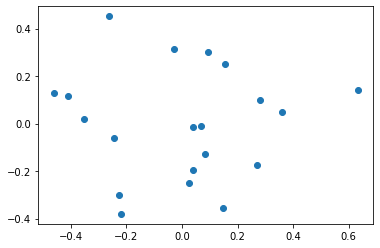

In [185]:
import matplotlib.pyplot as plt

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])